#### Battery Capacity (C) ML Model —–→ Remaining Useful Life Prediction
feature engineering and regression modeling to predict battery capacity (C) at each cycle and then progressing to RUL estimation.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate, GroupKFold

In [2]:
# Load metadata
metadata = pd.read_csv('../data/metadata.csv')
metadata['cycle_count'] = metadata['test_id']
metadata['Capacity'] = pd.to_numeric(metadata['Capacity'], errors='coerce')

In [12]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD,temp_mean,temp_std,C_rate
0,charge,2008-04-02 13:08:17,24,B0005,0,1,00001.csv,NaN,NaN,NaN,0,NaN,25.324079,1.011951,2.015134
1,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371,32.572328,3.495804,1.009007
2,charge,2008-04-02 16:37:51,24,B0005,2,3,00003.csv,NaN,NaN,NaN,2,NaN,26.635623,1.358494,1.680991
3,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362,32.725235,3.435509,1.008410
4,charge,2008-04-02 20:55:40,24,B0005,4,5,00005.csv,NaN,NaN,NaN,4,NaN,26.778176,1.371851,1.692204


In [3]:
# Feature: Depth of Discharge (DoD) for discharge cycles using Capacity from metadata
nominal_capacity = 2.0  # Update if your battery's nominal capacity is different
metadata['DoD'] = np.where(
    (metadata['type'] == 'discharge') & (metadata['Capacity'].notnull()),
    (metadata['Capacity'] / nominal_capacity) * 100,
    np.nan)

In [4]:
# Feature: Temperature statistics
def temp_stats(filename):
    try:
        df = pd.read_csv(f"../data/nasa_processed_data/{filename}")
        if 'Temperature_measured' in df.columns:
            return df['Temperature_measured'].mean(), df['Temperature_measured'].std()
        else:
            return np.nan, np.nan
    except Exception:
        return np.nan, np.nan
metadata[['temp_mean', 'temp_std']] = metadata.apply(
    lambda row: pd.Series(temp_stats(row['filename'])), axis=1
)

In [5]:
# Feature: Charge/Discharge rate (C-rate)
def c_rate(filename, nominal_capacity=2.0):
    try:
        df = pd.read_csv(f"../data/nasa_processed_data/{filename}")
        if 'Current_measured' in df.columns:
            return df['Current_measured'].abs().max() / nominal_capacity
        else:
            return np.nan
    except Exception:
        return np.nan
metadata['C_rate'] = metadata.apply(
    lambda row: c_rate(row['filename']), axis=1
)

In [6]:
# Only keep discharge cycles for capacity prediction
capacity_data = metadata[metadata['type'] == 'discharge'].copy()
capacity_data = capacity_data.reset_index(drop=True)

In [13]:
metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD,temp_mean,temp_std,C_rate
0,charge,2008-04-02 13:08:17,24,B0005,0,1,00001.csv,NaN,NaN,NaN,0,NaN,25.324079,1.011951,2.015134
1,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371,32.572328,3.495804,1.009007
2,charge,2008-04-02 16:37:51,24,B0005,2,3,00003.csv,NaN,NaN,NaN,2,NaN,26.635623,1.358494,1.680991
3,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362,32.725235,3.435509,1.008410
4,charge,2008-04-02 20:55:40,24,B0005,4,5,00005.csv,NaN,NaN,NaN,4,NaN,26.778176,1.371851,1.692204


## Features and Target
- Features: cycle_count, Depth of Discharge (DoD), mean temperature, temp_std, C_rate, ambient_temperature
- Target: Capacity (Ah)

In [7]:
features = ['cycle_count', 'DoD', 'temp_mean', 'temp_std', 'C_rate', 'ambient_temperature']
target = 'Capacity'

model_data = capacity_data[features + [target]].dropna().reset_index(drop=True)
X = model_data[features]
y = model_data[target]

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [15]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=19)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

Random Forest - MAE: 0.0007, RMSE: 0.0026, R2: 1.0000


In [16]:
# Extra Trees Regressor
etr_model = ExtraTreesRegressor(n_estimators=100, random_state=19)
etr_model.fit(X_train, y_train)
y_pred = etr_model.predict(X_test)
mae_etr = mean_absolute_error(y_test, y_pred)
rmse_etr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_etr = r2_score(y_test, y_pred)
print(f"Extra Trees - MAE: {mae_etr:.4f}, RMSE: {rmse_etr:.4f}, R2: {r2_etr:.4f}")

Extra Trees - MAE: 0.0010, RMSE: 0.0046, R2: 0.9999


In [18]:
# Training using XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=19)
xgb_model.fit(X_train, y_train)
# Predictions
y_prediction = xgb_model.predict(X_test)
# Evaluation
mae_xgb = mean_absolute_error(y_test, y_prediction)
mse_xgb = mean_squared_error(y_test, y_prediction)
rmse_xgb = np.sqrt(mse_xgb) # root mean squared error
r2_xgb = r2_score(y_test, y_prediction)
print(f"MAE_xgb: {mae_xgb:.2f}")
print(f"MSE_xgb: {mse_xgb:.2f}")
print(f"RMSE_xgb: {rmse_xgb:.2f}")
print(f"R-squared_xgb: {r2_xgb:.2f}")

MAE_xgb: 0.01
MSE_xgb: 0.00
RMSE_xgb: 0.04
R-squared_xgb: 0.99


In [21]:
# Reshape data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Scale the data
scaler = MinMaxScaler()
X_train_lstm = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_test_lstm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)


lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
# Predictions
y_prediction = lstm_model.predict(X_test_lstm)
# Evaluation
mae_lstm = mean_absolute_error(y_test, y_prediction)
mse_lstm = mean_squared_error(y_test, y_prediction)
rmse_lstm = np.sqrt(mse_lstm) # root mean squared error
r2_lstm = r2_score(y_test, y_prediction)
print(f"Extra Trees - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}")

Epoch 1/50


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6465
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2551
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2439
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2436
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2432
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2321
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2223
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2191
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2099
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1939
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1557
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1089
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0861
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0777
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676
Epoch 16/50
70/70 ━━━━━━━━━━━━

In [28]:
# MLP Regressor with hyperparameter tuning using RandomizedSearchCV
param_distributions = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu']
}
mlp = MLPRegressor(
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=19
)
mlp_search = RandomizedSearchCV(
    mlp,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=19
)
mlp_search.fit(X_train, y_train)

y_pred = mlp_search.predict(X_test)
mae_mlp = mean_absolute_error(y_test, y_pred)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))
r2_mlp = r2_score(y_test, y_pred)
print(f"MLP Regressor - MAE: {mae_mlp:.4f}, RMSE: {rmse_mlp:.4f}, R2: {r2_mlp:.4f}")

c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 12 candidates, totalling 36 fits
MLP Regressor - MAE: 0.0161, RMSE: 0.0274, R2: 0.9964


Let's try to see if Neural Network improves by
- feature scaling 
- broader hyperparameters search

In [30]:
# Feature Scaling for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# MLP Regressor with feature scaling
# mlp_scaled = MLPRegressor(
#     hidden_layer_sizes=[(64, 32),(128, 64), (128, 64, 32)],
#     activation='relu', #{'relu', 'logistic', 'tanh'}, #['relu', 'tanh', 'logistic'],
#     solver=['adam', 'sgd', 'lbfgs'],
#     alpha=0.0001,
#     learning_rate_init= [0.0005, 0.001],
#     max_iter=1000,
#     early_stopping=True,
#     random_state=19
# )


param_distributions = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0005, 0.001],
    'early_stopping': [True]
}
mlp_scaled = RandomizedSearchCV(
    mlp,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=19
)


mlp_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = mlp_scaled.predict(X_test_scaled)
mae_mlp_scaled = mean_absolute_error(y_test, y_pred_scaled)
rmse_mlp_scaled = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
r2_mlp_scaled = r2_score(y_test, y_pred_scaled)
print(f"MLP Regressor with Scaling - MAE: {mae_mlp_scaled:.4f}, RMSE: {rmse_mlp_scaled:.4f}, R2: {r2_mlp_scaled:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
MLP Regressor with Scaling - MAE: 0.0043, RMSE: 0.0056, R2: 0.9998


MLP performance improved!

In [37]:
# Model comparison table

model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Extra Trees', 'LSTM', 'MLP Regressor'],
    'MAE': [mae, mae_etr, mae_lstm, mae_mlp_scaled],
    'RMSE': [rmse, rmse_etr, mae_lstm, rmse_mlp_scaled],
    'R2': [r2, r2_etr, mae_lstm, r2_mlp_scaled]
})
model_comparison

,Model,MAE,RMSE,R2
0,Random Forest,0.000660,0.002561,0.999969
1,Extra Trees,0.000968,0.004603,0.999900
2,LSTM,0.072970,0.072970,0.072970
3,MLP Regressor,0.004273,0.005636,0.999850


### Conclusion
- Prediction battery capacity (C) using engineered features and regression models.
- Best performance 
    1. Random Forest
    2. Extra Trees
    3. MLP Regressor (Neural Network)
    4. LSTM- Long Short-Term Memory network

## Predicting Remaining Useful Life (RUL)
Predict the Remaining Useful Life (RUL) of the battery using the features engineered earlier and a machine learning model.

In [27]:
# Debugging: Inspect cycle_count and battery_id columns
# print("Unique battery_ids:", capacity_data['battery_id'].unique())
# print("Cycle count statistics:", capacity_data['cycle_count'].describe())

# Calculate Remaining Useful Life (RUL)
capacity_data['RUL'] = capacity_data.groupby('battery_id')['cycle_count'].transform(lambda x: x.max() - x)
capacity_data.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_count,DoD,temp_mean,temp_std,C_rate,RUL
0,discharge,2008-04-02 15:25:41,24,B0005,1,2,00002.csv,1.856487,NaN,NaN,1,92.824371,32.572328,3.495804,1.009007,612
1,discharge,2008-04-02 19:43:48,24,B0005,3,4,00004.csv,1.846327,NaN,NaN,3,92.316362,32.725235,3.435509,1.008410,610
2,discharge,2008-04-03 00:01:06,24,B0005,5,6,00006.csv,1.835349,NaN,NaN,5,91.767460,32.642862,3.388174,1.008287,608
3,discharge,2008-04-03 04:16:37,24,B0005,7,8,00008.csv,1.835263,NaN,NaN,7,91.763126,32.514876,3.395306,1.007968,606
4,discharge,2008-04-03 08:33:25,24,B0005,9,10,00010.csv,1.834646,NaN,NaN,9,91.732275,32.382349,3.404667,1.008713,604


In [39]:
# Features and target for RUL prediction
rul_features = ['cycle_count', 'DoD', 'temp_mean', 'temp_std', 'C_rate', 'ambient_temperature']
rul_target = 'RUL'

rul_data = capacity_data[rul_features + [rul_target]].dropna().reset_index(drop=True)
X_rul = rul_data[rul_features]
y_rul = rul_data[rul_target]

In [40]:
# Train-test split for RUL prediction
X_rul_train, X_rul_test, y_rul_train, y_rul_test = train_test_split(X_rul, y_rul, test_size=0.2, random_state=19)

In [51]:
# Random Forest Regressor for RUL prediction
rul_rf_model = RandomForestRegressor(n_estimators=100, random_state=19)
rul_rf_model.fit(X_rul_train, y_rul_train)

best_rf = rul_rf_model  # No best_estimator_ for RandomForestRegressor, used later for CV
y_rul_pred = rul_rf_model.predict(X_rul_test)

# Evaluate the model
rul_mae = mean_absolute_error(y_rul_test, y_rul_pred)
rul_rmse = np.sqrt(mean_squared_error(y_rul_test, y_rul_pred))
rul_r2 = r2_score(y_rul_test, y_rul_pred)
print(f"RUL Prediction - MAE: {rul_mae:.4f}, RMSE: {rul_rmse:.4f}, R2: {rul_r2:.4f}")

RUL Prediction - MAE: 12.1477, RMSE: 34.9877, R2: 0.9383


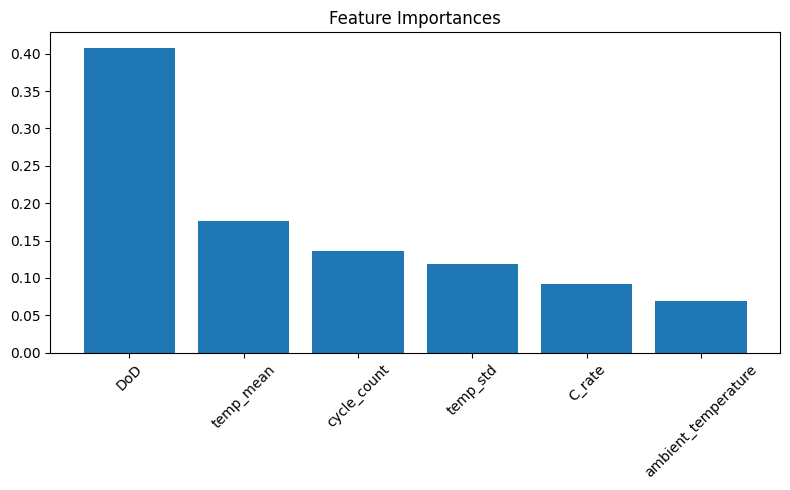

In [46]:
#Feature importance for Random Forest
importances_rul = rul_rf_model.feature_importances_
indices_rul = np.argsort(importances_rul)[::-1]
plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(rul_features)), importances_rul[indices_rul], align="center")
plt.xticks(range(len(rul_features)), [rul_features[i] for i in indices_rul], rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# MLP Regressor with hyperparameter tuning using GridSearchCV for RUL prediction
param_distributions_rul = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0005, 0.001],
    'early_stopping': [True]
}
mlp_rul = MLPRegressor(
    max_iter=1000,
    random_state=19
)
mlp_rul_search = RandomizedSearchCV(
    mlp_rul,
    param_distributions=param_distributions_rul,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=19
)
mlp_rul_search.fit(X_rul_train, y_rul_train)
best_mlp = mlp_rul_search.best_estimator_
y_rul_pred = mlp_rul_search.predict(X_rul_test)
# Evaluate the model
rul_mae_mlp = mean_absolute_error(y_rul_test, y_rul_pred)
rul_rmse_mlp = np.sqrt(mean_squared_error(y_rul_test, y_rul_pred))
rul_r2_mlp = r2_score(y_rul_test, y_rul_pred)

print('Best MLP Parameters:', mlp_rul_search.best_params_)
print(f"RUL Prediction with MLP - MAE: {rul_mae_mlp:.4f}, RMSE: {rul_rmse_mlp:.4f}, R2: {rul_r2_mlp:.4f}")
# # Plotting the results
# plt.figure(figsize=(12, 6))
# plt.plot(y_rul_test.values, label='True RUL', color='blue')
# plt.plot(y_rul_pred, label='Predicted RUL', color='red')
# plt.title('True vs Predicted RUL')
# plt.xlabel('Sample Index')
# plt.ylabel('Remaining Useful Life (RUL)')
# plt.legend()
# plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best MLP Parameters: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64), 'early_stopping': True, 'alpha': 0.0001, 'activation': 'tanh'}
RUL Prediction with MLP - MAE: 21.9906, RMSE: 43.9113, R2: 0.9028


the results are comparable to **Random Forest**. 

Let's see if Model performance can be further improved.
- Increase max iterations
- Features engg:
  Ambient temperature feature has importance less than 0.10
  (From From random forest result)
  Trial of result after removing this feature 
- Cross-validation (increment)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py"

Best MLP Parameters: {'solver': 'adam', 'max_iter': 3000, 'learning_rate_init': 0.0005, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (128, 64, 32), 'batch_size': 64, 'alpha': 0.0001, 'activation': 'tanh'}
RUL Prediction with MLP - MAE: 24.3709, RMSE: 47.3450, R2: 0.8870


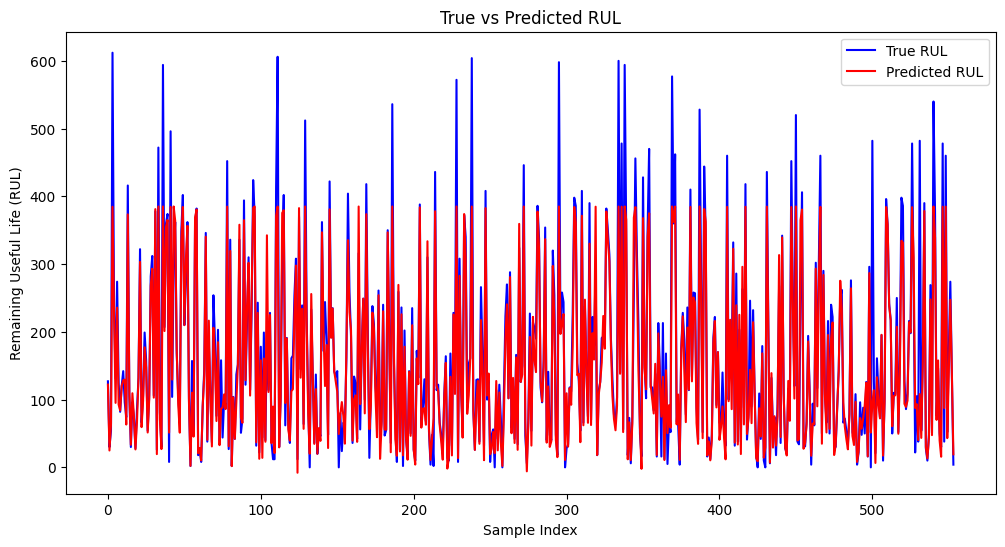

In [52]:
# MLP Regressor with hyperparameter tuning using GridSearchCV for RUL prediction
param_distributions_rul = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': [ 'sgd', 'lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
    'max_iter': [1000, 2000, 3000],
    'batch_size': [16, 32, 64], #used for sgd solver
    'learning_rate': ['constant', 'adaptive'], #used for sgd solver
    'early_stopping': [True]
}
mlp_rul = MLPRegressor(
    # max_iter=1000,
    random_state=19
)
mlp_rul_search = RandomizedSearchCV(
    mlp_rul,
    param_distributions=param_distributions_rul,
    n_iter=40,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=19
)
mlp_rul_search.fit(X_rul_train, y_rul_train)
best_mlp = mlp_rul_search.best_estimator_
y_rul_pred = mlp_rul_search.predict(X_rul_test)
# Evaluate the model
rul_mae_mlp = mean_absolute_error(y_rul_test, y_rul_pred)
rul_rmse_mlp = np.sqrt(mean_squared_error(y_rul_test, y_rul_pred))
rul_r2_mlp = r2_score(y_rul_test, y_rul_pred)

print('Best MLP Parameters:', mlp_rul_search.best_params_)
print(f"RUL Prediction with MLP - MAE: {rul_mae_mlp:.4f}, RMSE: {rul_rmse_mlp:.4f}, R2: {rul_r2_mlp:.4f}")
# # Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_rul_test.values, label='True RUL', color='blue')
plt.plot(y_rul_pred, label='Predicted RUL', color='red')
plt.title('True vs Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.show()


In [55]:
rul_features

['cycle_count',
 'DoD',
 'temp_mean',
 'temp_std',
 'C_rate',
 'ambient_temperature']

In [63]:
# rul_data = capacity_data[rul_features[:-1] + [rul_target]].dropna().reset_index(drop=True)
# X_rul_mod = rul_data[rul_features[:-1]]
# y_rul_mod = rul_data[rul_target]

# # Train-test split for RUL prediction
# X_rul_train_m, X_rul_test_m, y_rul_train_m, y_rul_test_m = train_test_split(X_rul_mod, y_rul_mod, test_size=0.2, random_state=19)

#Adding standard scaler
scaler = StandardScaler()
X_rul_train_scaled = scaler.fit_transform(X_rul_train)
X_rul_test_scaled = scaler.transform(X_rul_test)

c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=40. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best MLP Parameters: {'max_iter': 2000, 'learning_rate': 'constant', 'early_stopping': True}
RUL Prediction with MLP - MAE: 15.1066, RMSE: 35.3948, R2: 0.9368


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


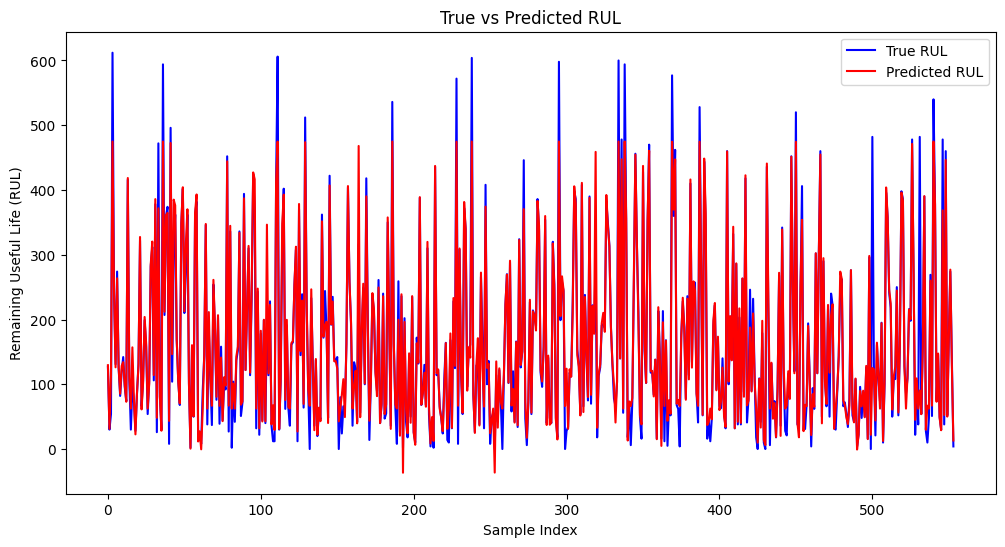

In [71]:
# MLP Regressor with hyperparameter tuning using GridSearchCV for RUL prediction
param_distributions_rul = {
    # 'hidden_layer_sizes': [(128, 64), (128, 64, 32), (256,128,64)], #(32,), (64,), (128,), (64, 32), 
    # 'activation': ['relu', 'tanh', 'logistic'],
    # 'solver': [ 'sgd', 'lbfgs', 'adam'],
    # 'alpha': [0.0001, 0.0005], #, 0.001, 0.01, 0.1
    # 'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
    'max_iter': [1000,2000],# 3000, 3500, 4000], #1000, 2000,
    # 'batch_size': [16, 32, 64], #used for sgd solver
    'learning_rate': ['constant', 'adaptive'], #used for sgd solver
    'early_stopping': [True]
}
mlp_rul = MLPRegressor(
    # max_iter=1000,
    hidden_layer_sizes=(64, 32),#(128, 64),
    solver='adam',
    alpha=0.0001,
    activation='tanh',
    learning_rate_init=0.001,
    # batch_size=64,
    # learning_rate='adaptive',
    random_state=33
)
mlp_rul_search = RandomizedSearchCV(
    mlp_rul,
    param_distributions=param_distributions_rul,
    n_iter=40,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=33
)
mlp_rul_search.fit(X_rul_train_scaled, y_rul_train)
best_mlp = mlp_rul_search.best_estimator_
y_rul_pred = mlp_rul_search.predict(X_rul_test_scaled)
# Evaluate the model
rul_mae_mlp = mean_absolute_error(y_rul_test, y_rul_pred)
rul_rmse_mlp = np.sqrt(mean_squared_error(y_rul_test, y_rul_pred))
rul_r2_mlp = r2_score(y_rul_test, y_rul_pred)

print('Best MLP Parameters:', mlp_rul_search.best_params_)
print(f"RUL Prediction with MLP - MAE: {rul_mae_mlp:.4f}, RMSE: {rul_rmse_mlp:.4f}, R2: {rul_r2_mlp:.4f}")
# # Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_rul_test.values, label='True RUL', color='blue')
plt.plot(y_rul_pred, label='Predicted RUL', color='red')
plt.title('True vs Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.show()


- Feature omission: 
--Does not improve the model. R-squared= 0.8870
- max_iter = 200
-- Model performance improves. R-squared = 0.9028
- Feature Scaling
-- *better than Random Forest* 
- Best Model performance : **MAE: 12.78, RMSE: 33.2403, R2: 0.9437**
- Seed number changes
    1. seed 42: MAE: 12.78, RMSE: 33.2403, R2: 0.9437
    2. seed 19: MAE: 11.9640, RMSE: 37.1105, R2: 0.9306
    3. seed 33: MAE: 14.6993, RMSE: 34.4553, R2: 0.9402

##### Model Validation & Visualization


In [69]:
# 1. Cross-Validation (on best Extra Trees and MLP models)
cv = 5
cv_scores_rf = cross_validate(best_rf, X_rul, y_rul, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_scores_mlp = cross_validate(best_mlp, scaler.transform(X_rul), y_rul, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)

print(f"\nRandom Forest {cv}-fold CV Results:")
print(f"MAE: {-cv_scores_rf['test_neg_mean_absolute_error'].mean():.2f} ± {cv_scores_rf['test_neg_mean_absolute_error'].std():.2f}")
print(f"RMSE: {np.sqrt(-cv_scores_rf['test_neg_mean_squared_error'].mean()):.2f}")
print(f"R²: {cv_scores_rf['test_r2'].mean():.2f}")

print(f"\nMLPRegressor {cv}-fold CV Results:")
print(f"MAE: {-cv_scores_mlp['test_neg_mean_absolute_error'].mean():.2f} ± {cv_scores_mlp['test_neg_mean_absolute_error'].std():.2f}")
print(f"RMSE: {np.sqrt(-cv_scores_mlp['test_neg_mean_squared_error'].mean()):.2f}")
print(f"R²: {cv_scores_mlp['test_r2'].mean():.2f}")


Random Forest 5-fold CV Results:
MAE: 104.81 ± 48.29
RMSE: 159.26
R²: -0.57

MLPRegressor 5-fold CV Results:
MAE: 107.88 ± 59.32
RMSE: 149.30
R²: -0.25


In [83]:
# Compare training and validation metrics for overfitting analysis
train_mae_rf = -cv_scores_rf['train_neg_mean_absolute_error'].mean()
train_r2_rf = cv_scores_rf['train_r2'].mean()
val_mae_rf = -cv_scores_rf['test_neg_mean_absolute_error'].mean()
val_r2_rf = cv_scores_rf['test_r2'].mean()

train_mae_mlp = -cv_scores_mlp['train_neg_mean_absolute_error'].mean()
train_r2_mlp = cv_scores_mlp['train_r2'].mean()
val_mae_mlp = -cv_scores_mlp['test_neg_mean_absolute_error'].mean()
val_r2_mlp = cv_scores_mlp['test_r2'].mean()

print("Random Forest Training vs Validation:")
print(f"MAE (Train): {train_mae_rf:.2f}, R² (Train): {train_r2_rf:.2f}")
print(f"MAE (Validation): {val_mae_rf:.2f}, R² (Validation): {val_r2_rf:.2f}")

print("\nMLP Regressor Training vs Validation:")
print(f"MAE (Train): {train_mae_mlp:.2f}, R² (Train): {train_r2_mlp:.2f}")
print(f"MAE (Validation): {val_mae_mlp:.2f}, R² (Validation): {val_r2_mlp:.2f}")

Random Forest Training vs Validation:
MAE (Train): 3.03, R² (Train): 1.00
MAE (Validation): 104.81, R² (Validation): -0.57

MLP Regressor Training vs Validation:
MAE (Train): 24.97, R² (Train): 0.83
MAE (Validation): 107.88, R² (Validation): -0.25


In [ ]:
# Compare training and validation metrics for overfitting analysis
train_mae_rf = -cv_scores_rf['train_neg_mean_absolute_error'].mean()
train_r2_rf = cv_scores_rf['train_r2'].mean()
val_mae_rf = -cv_scores_rf['test_neg_mean_absolute_error'].mean()
val_r2_rf = cv_scores_rf['test_r2'].mean()

train_mae_mlp = -cv_scores_mlp['train_neg_mean_absolute_error'].mean()
train_r2_mlp = cv_scores_mlp['train_r2'].mean()
val_mae_mlp = -cv_scores_mlp['test_neg_mean_absolute_error'].mean()
val_r2_mlp = cv_scores_mlp['test_r2'].mean()

print("Random Forest Training vs Validation:")
print(f"MAE (Train): {train_mae_rf:.2f}, R² (Train): {train_r2_rf:.2f}")
print(f"MAE (Validation): {val_mae_rf:.2f}, R² (Validation): {val_r2_rf:.2f}")

print("\nMLP Regressor Training vs Validation:")
print(f"MAE (Train): {train_mae_mlp:.2f}, R² (Train): {train_r2_mlp:.2f}")
print(f"MAE (Validation): {val_mae_mlp:.2f}, R² (Validation): {val_r2_mlp:.2f}")

In [80]:
# Present results in a DataFrame with rounded float values
cv_results_df = pd.DataFrame({
    'Model': ['Random Forest', 'MLPRegressor'],
    'MAE Mean': [-cv_scores_rf['test_neg_mean_absolute_error'].mean(), -cv_scores_mlp['test_neg_mean_absolute_error'].mean()],
    'MAE Std': [cv_scores_rf['test_neg_mean_absolute_error'].std(), cv_scores_mlp['test_neg_mean_absolute_error'].std()],
    'RMSE': [np.sqrt(-cv_scores_rf['test_neg_mean_squared_error'].mean()), np.sqrt(-cv_scores_mlp['test_neg_mean_squared_error'].mean())],
    'R2': [cv_scores_rf['test_r2'].mean(), cv_scores_mlp['test_r2'].mean()]
})
cv_results_df = cv_results_df.round(2)
cv_results_df

,Model,MAE Mean,MAE Std,RMSE,R2
0,Random Forest,104.81,48.29,159.26,-0.57
1,MLPRegressor,107.88,59.32,149.30,-0.25


In [76]:
rul_data['battery_id'] = capacity_data.loc[rul_data.index, 'battery_id'].values
rul_data


,cycle_count,DoD,temp_mean,temp_std,C_rate,RUL,battery_id
0,1,92.824371,32.572328,3.495804,1.009007,612,B0005
1,3,92.316362,32.725235,3.435509,1.008410,610,B0005
2,5,91.767460,32.642862,3.388174,1.008287,608,B0005
3,7,91.763126,32.514876,3.395306,1.007968,606,B0005
4,9,91.732275,32.382349,3.404667,1.008713,604,B0005
...,...,...,...,...,...,...,...
2764,240,56.510957,10.116013,1.930534,0.998278,10,B0056
2765,242,56.293597,10.332244,2.199819,0.998194,8,B0056
2766,244,57.150541,10.278021,2.093572,0.998334,6,B0056
2767,248,56.863659,10.263503,1.998990,0.998222,2,B0056


In [77]:
group_kfold = GroupKFold(n_splits=5)
groups = rul_data['battery_id'] 
cv_scores_mlp_gkf = cross_validate(
    best_mlp,
    scaler.transform(X_rul),
    y_rul,
    cv=group_kfold.split(X_rul, y_rul, groups),
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
    return_train_score=True
)


c:\Users\pushk\miniconda3\envs\devenvpy10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


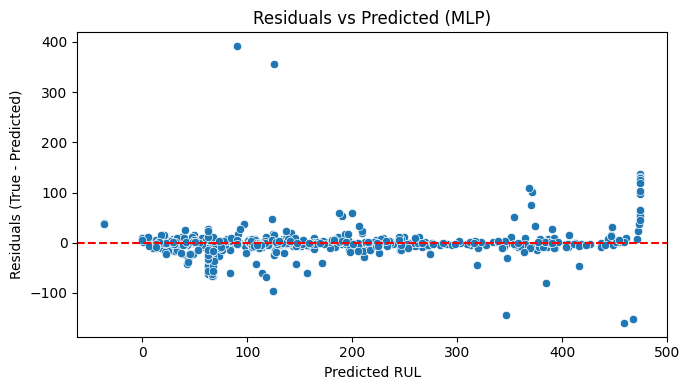

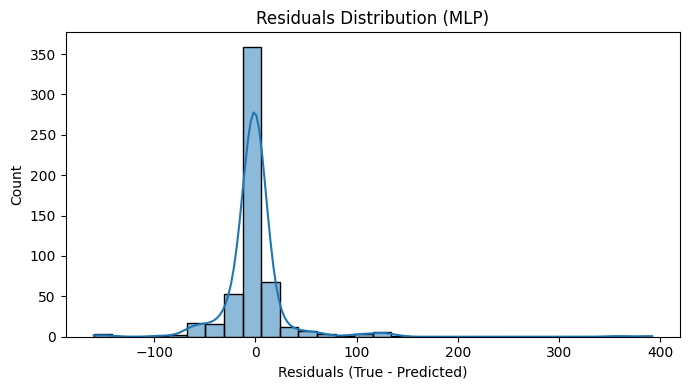

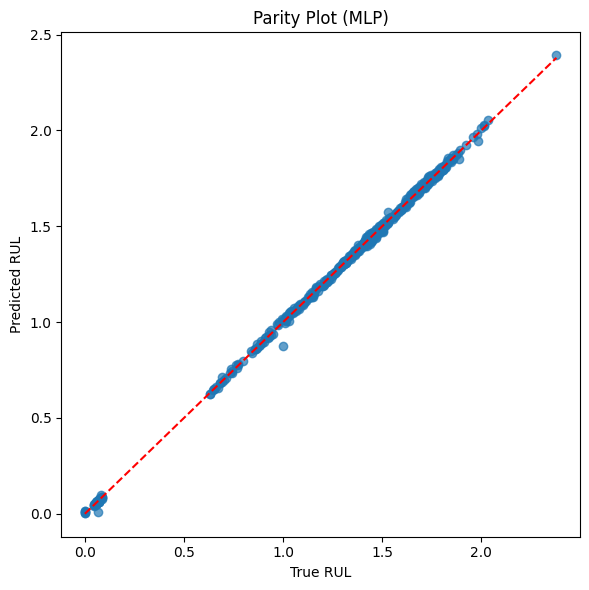

In [78]:
# 2. Residual Analysis (for best MLP on test set)
residuals = y_rul_test - y_rul_pred
plt.figure(figsize=(7,4))
sns.scatterplot(x=y_rul_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted (MLP)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals (True - Predicted)')
plt.title('Residuals Distribution (MLP)')
plt.tight_layout()
plt.show()

# 3. Parity Plot (Predicted vs True)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Parity Plot (MLP)')
plt.tight_layout()
plt.show()

## Conclusions:

1. Clearly there is an issue of **Overfitting** occurring which causes the model to perform really well on training data but perform poorly on validation data.

2. Another probable resason for R-squared value to be negative: **Data leakage**, Test data may be leaking into training data through *feature engineering* or *scaling*.

3. Models like MLP Regressor and LSTM are **prone to overfitting** especially with limited data or insufficient regularization. 

4. The **Residual Analysis** shows patterned residuals denoting the model performs well for some predictions but poorly for others.

5. Further TODOs to resolve the issue of overfitting:
- Data leakage check.
- Raw data distribution check.
- Removal of low importance feature
- **Group splitting**-> splitting of battery_id into groups to avoid data leakage across batteries.